# Import Necessary Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mnist

# Build A convoluation function

In [49]:
class Convolution:
    def __init__(self):
        self.last_kernel = None
        self.last_image = None
        self.filter_size = None
        self.last_padded_image = None
        self.movements = None

    def apply_padding(self, padding_type, image, filter_size):
        """Applies padding to the image based on the padding type."""
        if padding_type in ['zero', 'same']:
            image_size = len(image[0])
            padding_size = image_size - (image_size - filter_size + 1)
            padded_image = np.pad(image, [(padding_size,), (padding_size,)], mode='constant')
            return padded_image, image_size + padding_size
        elif padding_type == 'valid':
            return image, len(image[0])

    def convolve(self, image, kernel, filter_size):
        """Performs convolution on the image using the given kernel and filter size."""
        self.last_kernel = kernel
        self.last_image = image
        self.filter_size = filter_size
        padded_image, image_size = self.apply_padding('zero', image, filter_size)
        self.last_padded_image = padded_image
        self.movements = image_size - filter_size + 1
        convolved_image = np.zeros((self.movements, self.movements))
        for row in range(self.movements):
            for col in range(self.movements):
                segment = padded_image[row:row+filter_size, col:col+filter_size] * kernel
                convolved_image[row, col] = np.sum(segment)
        return convolved_image

    def backprop(self, gradients, learning_rate):
        """Performs backpropagation based on the gradients and learning rate."""
        padded_gradients, _ = self.apply_padding('zero', gradients, self.filter_size)
        dl_dkernel = 0
        for row in range(self.movements):
            for col in range(self.movements):
                dl_dkernel += padded_gradients[row:row+self.filter_size, col:col+self.filter_size] * self.last_padded_image[row:row+self.filter_size, col:col+self.filter_size]
        updated_kernel = self.last_kernel - learning_rate * dl_dkernel
        return updated_kernel


# Build A Pooling Layer For CNN supports two type of Pooling: Average and Max

In [50]:
class Pooling:
    def __init__(self):
        # Initialize variables
        self.max_locations = []  # Stores the locations of maximum values for max pooling
        self.mean_values = []  # Stores the mean values for average pooling
        self.last_convolved_image = None  # Stores the last convolved image
        self.pool_size = None  # Stores the size of the pooling window
        self.last_padded_image = None  # Stores the last padded image if padding is needed
        self.newsize = None  # Stores the new size of the image after padding if needed

    def pooling(self, convolved_image, pool_size):
        # Max pooling operation
        self.initialize_variables(convolved_image, pool_size)
        return self.apply_pooling('max')

    def avg_pooling(self, convolved_image, pool_size):
        # Average pooling operation
        self.initialize_variables(convolved_image, pool_size)
        return self.apply_pooling('average')

    def initialize_variables(self, convolved_image, pool_size):
        # Initialize variables for pooling operations
        self.max_locations = []
        self.mean_values = []
        self.pool_size = pool_size
        self.last_convolved_image = convolved_image

        # Pad the convolved image if needed
        if len(convolved_image[0]) % 2 != 0:
            self.last_padded_image = np.pad(convolved_image, [(0, 1), (0, 1)], mode='constant', constant_values=(-1e30))
        else:
            self.last_padded_image = convolved_image

        self.newsize = len(self.last_padded_image[0])

    def apply_pooling(self, pool_type):
        # Apply the pooling operation (max or average)
        pooled_image_dim = int(self.newsize / self.pool_size)
        pooled_image = np.zeros((pooled_image_dim, pooled_image_dim))

        pool_filter = np.ones((self.pool_size, self.pool_size))

        for rows in range(0, self.newsize, self.pool_size):
            for cols in range(0, self.newsize, self.pool_size):
                segment = self.last_padded_image[rows:rows + self.pool_size, cols:cols + self.pool_size] * pool_filter

                if pool_type == 'max':
                    max_val = np.max(segment)
                    location = np.where(self.last_convolved_image == np.amax(segment))
                    location = list(zip(location[0], location[1]))[0]
                    self.max_locations.append(location)
                    pooled_image[int(rows / self.pool_size), int(cols / self.pool_size)] = max_val
                elif pool_type == 'average':
                    mean_val = np.mean(segment)
                    self.mean_values.append(mean_val)
                    pooled_image[int(rows / self.pool_size), int(cols / self.pool_size)] = mean_val

        return pooled_image

    def create_mask(self, gradients):
        # Create a mask for max pooling backpropagation
        backprop_convolved_image = self.last_convolved_image.copy()
        flattened_gradients = gradients.flatten()

        for i, location in enumerate(self.max_locations):
            backprop_convolved_image[location[0], location[1]] = flattened_gradients[i]

        return backprop_convolved_image

    def distribute(self, gradients):
        # Distribute gradients for average pooling backpropagation
        backprop_convolved_image = self.last_padded_image.copy()

        for rows in range(0, self.newsize, self.pool_size):
            for cols in range(0, self.newsize, self.pool_size):
                backprop_convolved_image[rows:rows + self.pool_size, cols:cols + self.pool_size] =+ gradients[int(rows / self.pool_size), int(cols / self.pool_size)]

        return backprop_convolved_image

    def backprop(self, pool_type, gradients):
        # Backpropagation for pooling layers
        if pool_type == 'max':
            return self.create_mask(gradients)
        elif pool_type == 'average':
            return self.distribute(gradients)


# Build A Activation Layer with 0.001 learning rate

In [51]:
class ActivatedLayer():
    def __init__(self, input_len, classes):
        self.weights = np.random.randn(input_len, classes) / input_len+1
        self.biases = np.zeros(classes)

    def softmax_layer(self, input_image):
        # Calculate the output of the activated layer by multiplying the weights with the input image and adding the biases , defining softmax function for output layer which is used in neural networks in final layer
        output = np.dot(self.weights.T, input_image) + self.biases.T 
        exponents = np.exp(output - np.max(output, axis=0, keepdims=True))
        activated_output = exponents / np.sum(exponents) + self.biases
        self.prev_exponents = exponents
        self.prev_activated_output = activated_output
        self.prev_output = output
        self.prev_input_image = input_image
        return activated_output

    def backprop(self, dL_dactivation_label):
        for i, v in enumerate(dL_dactivation_label):
            if v != 0: 
                dactivation_dnonactivated = -np.exp(self.prev_exponents[i]) * np.exp(self.prev_exponents) / np.square(np.sum(self.prev_exponents))
                # from previous layer, we have the derivative of the non activated output with respect to the input
                dactivation_dnonactivated[i] = np.exp(self.prev_exponents[i]) * (np.sum(self.prev_exponents) - np.exp(self.prev_exponents[i])) / np.square(np.sum
                (self.prev_exponents))
                # from previous layer, we have the derivative of the non activated output with respect to the weights
                # Initialize the derivative of the non activated output with respect to the weights
                dnonactivation_dw = self.prev_input_image
                # Initialize the derivative of the non activated output with respect to the biases
                dnonactivation_db = 1
                # Non activated input is the output of the previous layer
                dnonactivation_dinput = self.weights 
                # @ is used for matrix multiplication 
                dL_dW = dnonactivation_dw[np.newaxis].T @ ((v * dactivation_dnonactivated)[np.newaxis])  
                dL_dB = (v * dactivation_dnonactivated) * dnonactivation_db
                dL_dinput = dnonactivation_dinput @ (v * dactivation_dnonactivated)  
                # Update weights and biases
                self.weights -= 0.001 * dL_dW 
                self.biases -= 0.001 * dL_dB  
                return dL_dinput


# Create dataset load function

In [52]:
def load_data():
    train_images = mnist.train_images()
    train_labels = mnist.train_labels()

    test_images = mnist.test_images()
    test_labels = mnist.test_labels()
    return train_images, train_labels, test_images, test_labels

# Plot Losses

In [53]:

def plot_log_losses(log_losses):
    plt.plot(log_losses)
    plt.title('Log Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.show()

# Plot Accuracy

In [54]:

def plot_accuracies(accuracies):
    plt.plot(accuracies)
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Create Windows for CNN Model

In [55]:

def window(filter_size):
    kernel = np.random.randn(filter_size,filter_size)/5
    return kernel


# Create Kernel Creation Function

In [56]:

def create_kernels(num_kernels):
    kernels = []
    for k in range(num_kernels):
        kernel = window(3)
        kernels.append(kernel)
    return kernels

# Create Training Function

In [57]:
def train_model(kernels, test_images, test_labels, num_epochs):
    accuracies = []
    log_losses = []
    for epochs in range(num_epochs):
        correct = 0
        incorrect = 0
        log_loss = 0
        for i, v in zip(test_images[:50], test_labels[:50]):
            i = (i / 255) - 0.5
            final_volume = []
            for k in range(len(kernels)):
                kernel = kernels[k]
                convolution = Convolution()
                convolved_image = convolution.convolve(i, kernel, 3)
                pool_layer = Pooling()
                pooled_image = pool_layer.avg_pooling(convolved_image, 2)
                final_volume.append(pooled_image)
            final_volume = np.array(final_volume)
            flattened_volume = final_volume.flatten()
            activation_layer = ActivatedLayer(len(flattened_volume), 10)
            output = activation_layer.softmax_layer(flattened_volume)
            log_loss = -np.log(output[v] + 1e-7)
            if np.argmax(output) == v:
                correct += 1
            else:
                incorrect += 1
            dL_dactivation_label = np.zeros(10)
            dL_dactivation_label[v] = -1 / (output[v] + 1e-7)
            softmax_input_derivative = activation_layer.backprop(dL_dactivation_label)
            pooling_layer_back_input = softmax_input_derivative.reshape(final_volume.shape)
            backprop_convolve_volume = []
            for i in pooling_layer_back_input:
                backprop = pool_layer.distribute(i)
                backprop_convolve_volume.append(backprop)
            backprop_convolve_volume = np.array(backprop_convolve_volume)
            for i in backprop_convolve_volume:
                new_kernel = convolution.backprop(i, -0.001)
                kernels[k] = new_kernel
        accuracies.append(correct / (incorrect + correct))
        log_losses.append(log_loss)
    return accuracies, log_losses

# Load data

In [58]:

train_images, train_labels, test_images, test_labels = load_data()


# Create kernels

In [59]:

kernels = create_kernels(5)

# Train model

In [60]:

accuracies, log_losses = train_model(kernels, test_images, test_labels, 15)


# Plot Graphs


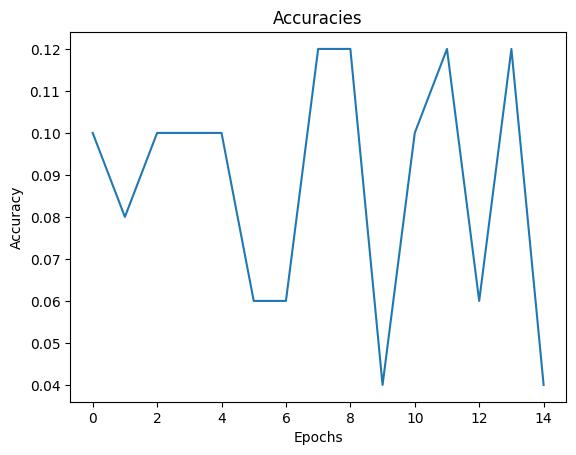

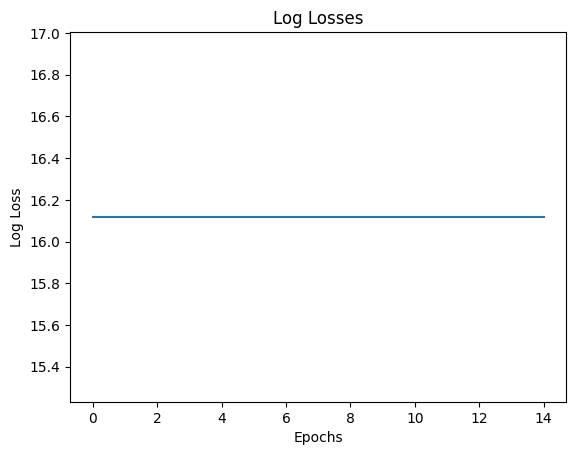

In [61]:
plot_accuracies(accuracies)
plot_log_losses(log_losses)